<a href="https://colab.research.google.com/github/zkhandker/rupi-kaur/blob/main/Word2vec_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies 


In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1
import re

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
## assert len(tf.config.list_physical_devices('GPU')) > 0
import pathlib

     |████████████████████████████████| 2.1MB 6.7MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115442 sha256=1a7d8cbbf8f923937d725422161745eed472019351e1cbf0a9e97dd6499854bc
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


## Load Poems 


In [3]:
path_to_file = tf.keras.utils.get_file('combined2', 'https://raw.githubusercontent.com/zkhandker/rupi-kaur/main/data/combined2.txt')
with open(path_to_file) as f: 
  poems = f.read()
  #print(poems)

73728/66843 [=================================] - 0s 0us/step


## Vectorize Poems 


In [4]:
#clean up the data, get rid of punctuations 
poems=poems.replace('í',"\'")
tokens = list(re.sub("[^\w\s]", "", poems).lower().split())
print(len(tokens))

13290


In [5]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [6]:
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
embedding_dim = 50
# Use the downloaded vectors as usual:
glove_vectors.most_similar('twitter')
glove_vectors["you"]

[==================================================] 100.0% 66.0/66.0MB downloaded


array([-1.0919e-03,  3.3324e-01,  3.5743e-01, -5.4041e-01,  8.2032e-01,
       -4.9391e-01, -3.2588e-01,  1.9972e-03, -2.3829e-01,  3.5554e-01,
       -6.0655e-01,  9.8932e-01, -2.1786e-01,  1.1236e-01,  1.1494e+00,
        7.3284e-01,  5.1182e-01,  2.9287e-01,  2.8388e-01, -1.3590e+00,
       -3.7951e-01,  5.0943e-01,  7.0710e-01,  6.2941e-01,  1.0534e+00,
       -2.1756e+00, -1.3204e+00,  4.0001e-01,  1.5741e+00, -1.6600e+00,
        3.7721e+00,  8.6949e-01, -8.0439e-01,  1.8390e-01, -3.4332e-01,
        1.0714e-02,  2.3969e-01,  6.6748e-02,  7.0117e-01, -7.3702e-01,
        2.0877e-01,  1.1564e-01, -1.5190e-01,  8.5908e-01,  2.2620e-01,
        1.6519e-01,  3.6309e-01, -4.5697e-01, -4.8969e-02,  1.1316e+00],
      dtype=float32)

In [7]:
# create a weight matrix for words in training docs
embedding_matrix = []

vocab, index = {}, 0 # start indexing from 0
for token in tokens:
  if (token not in vocab) and (token in glove_vectors.vocab):
    vocab[token] = index
    index += 1
    embedding_vector = glove_vectors[token]
    if embedding_vector is not None:
        embedding_matrix.append(embedding_vector)
vocab_size = len(vocab)
print(vocab)
print(vocab_size)

embedding_matrix=np.array(embedding_matrix)
embedding_matrix.shape

{'how': 0, 'is': 1, 'it': 2, 'so': 3, 'easy': 4, 'for': 5, 'you': 6, 'to': 7, 'be': 8, 'kind': 9, 'people': 10, 'he': 11, 'asked': 12, 'milk': 13, 'and': 14, 'honey': 15, 'dripped': 16, 'from': 17, 'my': 18, 'lips': 19, 'as': 20, 'i': 21, 'answered': 22, 'cause': 23, 'have': 24, 'not': 25, 'been': 26, 'me': 27, 'the': 28, 'first': 29, 'boy': 30, 'that': 31, 'kissed': 32, 'held': 33, 'shoulders': 34, 'down': 35, 'like': 36, 'handlebars': 37, 'of': 38, 'bicycle': 39, 'ever': 40, 'rode': 41, 'was': 42, 'five': 43, 'had': 44, 'smell': 45, 'starvation': 46, 'on': 47, 'his': 48, 'which': 49, 'picked': 50, 'up': 51, 'father': 52, 'feasting': 53, 'mother': 54, 'at': 55, '4': 56, 'am': 57, 'teach': 58, 'body': 59, 'giving': 60, 'those': 61, 'wanted': 62, 'should': 63, 'feel': 64, 'anything': 65, 'less': 66, 'than': 67, 'whole': 68, 'god': 69, 'did': 70, 'empty': 71, '425': 72, 'ive': 73, 'sex': 74, 'she': 75, 'said': 76, 'but': 77, 'dont': 78, 'know': 79, 'what': 80, 'making': 81, 'love': 82, '

(1349, 50)

In [8]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: 'how', 1: 'is', 2: 'it', 3: 'so', 4: 'easy', 5: 'for', 6: 'you', 7: 'to', 8: 'be', 9: 'kind', 10: 'people', 11: 'he', 12: 'asked', 13: 'milk', 14: 'and', 15: 'honey', 16: 'dripped', 17: 'from', 18: 'my', 19: 'lips', 20: 'as', 21: 'i', 22: 'answered', 23: 'cause', 24: 'have', 25: 'not', 26: 'been', 27: 'me', 28: 'the', 29: 'first', 30: 'boy', 31: 'that', 32: 'kissed', 33: 'held', 34: 'shoulders', 35: 'down', 36: 'like', 37: 'handlebars', 38: 'of', 39: 'bicycle', 40: 'ever', 41: 'rode', 42: 'was', 43: 'five', 44: 'had', 45: 'smell', 46: 'starvation', 47: 'on', 48: 'his', 49: 'which', 50: 'picked', 51: 'up', 52: 'father', 53: 'feasting', 54: 'mother', 55: 'at', 56: '4', 57: 'am', 58: 'teach', 59: 'body', 60: 'giving', 61: 'those', 62: 'wanted', 63: 'should', 64: 'feel', 65: 'anything', 66: 'less', 67: 'than', 68: 'whole', 69: 'god', 70: 'did', 71: 'empty', 72: '425', 73: 'ive', 74: 'sex', 75: 'she', 76: 'said', 77: 'but', 78: 'dont', 79: 'know', 80: 'what', 81: 'making', 82: 'love', 8

In [9]:
vectorized_poems = np.array([vocab[word] for word in vocab.keys()])
print(vectorized_poems)

[   0    1    2 ... 1346 1347 1348]


In [10]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(poems[:10]), vectorized_poems[:10]))
# check that vectorized_poems is a numpy array
assert isinstance(vectorized_poems, np.ndarray), "returned result should be a numpy array"

'how is it ' ---- characters mapped to int ----> [0 1 2 3 4 5 6 7 8 9]


## Define Batch 


In [11]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_poems, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [12]:
x_batch, y_batch = get_batch(vectorized_poems, seq_length=5, batch_size=1)

In [13]:
print(x_batch)
print(y_batch)

[[227 228 229 230 231]]
[[228 229 230 231 232]]


## Define RNN 


In [14]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [15]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), batch_input_shape=[batch_size, None], trainable=False),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units), 
    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size. 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the chance to change these later.
model = build_model(len(vocab), embedding_dim, rnn_units=1024, batch_size=32)

In [16]:
len(vocab)

1349

## Test Untrained RNN 


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 50)            67450     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          4403200   
_________________________________________________________________
dense (Dense)                (32, None, 1349)          1382725   
Total params: 5,853,375
Trainable params: 5,785,925
Non-trainable params: 67,450
_________________________________________________________________


In [40]:
x, y = get_batch(vectorized_poems, seq_length=10, batch_size=10)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

print("Input: ")
print([inverse_vocab[i] for i in x[0]])
print("Output:")
print([inverse_vocab[i] for i in sampled_indices])

Input shape:       (10, 10)  # (batch_size, sequence_length)
Prediction shape:  (10, 10, 1349) # (batch_size, sequence_length, vocab_size)
Input: 
['proud', 'relieved', 'points', 'growing', 'remind', 'guest', 'warn', 'welcome', 'tear', 'powerful']
Output:
['feels', 'points', 'growing', 'remind', 'guest', 'warn', 'welcome', 'tear', 'powerful', 'completely']


## Train 


In [33]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 10, 1349)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       7.211638


In [57]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 300  # Increase this to train longer
batch_size = 32  # Experiment between 1 and 64
seq_length = 10  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

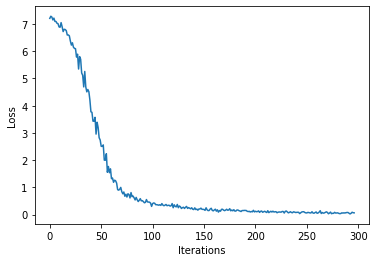

100%|██████████| 300/300 [02:30<00:00,  2.00it/s]


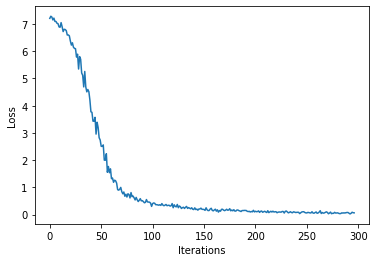

In [58]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat) 
  # Now, compute the gradients 
  grads = tape.gradient(loss, model.trainable_variables) 
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_poems, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    print(history[-1])
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [60]:
x, y = get_batch(vectorized_poems, seq_length=10, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
max_indices = np.argmax(pred[0], axis=1)

print("Input: ")
print([inverse_vocab[i] for i in x[0]])
print("Expected output: ")
print([inverse_vocab[i] for i in y[0]])
print("Actual sampled output:")
print([inverse_vocab[i] for i in sampled_indices])
print("Actual maximum-probability output:")
print([inverse_vocab[i] for i in max_indices])

Input shape:       (32, 10)  # (batch_size, sequence_length)
Prediction shape:  (32, 10, 1349) # (batch_size, sequence_length, vocab_size)
Input: 
['synthetic', 'beyond', 'add', 'years', 'combine', 'sweeter', 'falsehood', 'balanced', 'glow', 'angry']
Expected output: 
['beyond', 'add', 'years', 'combine', 'sweeter', 'falsehood', 'balanced', 'glow', 'angry', 'extremes']
Actual sampled output:
['beyond', 'add', 'years', 'combine', 'sweeter', 'falsehood', 'balanced', 'glow', 'angry', 'extremes']
Actual maximum-probability output:
['beyond', 'add', 'years', 'combine', 'sweeter', 'falsehood', 'balanced', 'glow', 'angry', 'extremes']


In [61]:
history[-1]

0.07960002

## Generate Poem 


In [63]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) #
# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 50)             67450     
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 1024)           4403200   
_________________________________________________________________
dense_5 (Dense)              (1, None, 1349)           1382725   
Total params: 5,853,375
Trainable params: 5,785,925
Non-trainable params: 67,450
_________________________________________________________________


In [64]:
start_string=['i']
input_eval = [vocab[s] for s in start_string]
print(input_eval)

[21]


In [65]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=75):
  # Evaluation step (generating text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [vocab[s] for s in start_string] # TODO
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # predictions = model('''TODO''')
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(inverse_vocab[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (' '.join(start_string) + ' ' + ' '.join(text_generated))

In [66]:
generated_text = generate_text(model, start_string=['my','body'], generation_length=50)

100%|██████████| 50/50 [00:00<00:00, 104.74it/s]


In [67]:
print(generated_text)

my body giving those wanted should feel anything less than whole god did empty 425 ive sex she said but dont know what making love feels came all this way give these things arent even looking abused abuser both undoing skin wasnt kissing ó mistaken him mind your were just convenient always
